In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd weights



In [2]:
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from matplotlib import pyplot as plt

import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'horse','ship', 'truck'}

background_classes = {'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog'}

# print(type(foreground_classes))

In [5]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)
    

In [6]:
def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img#.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

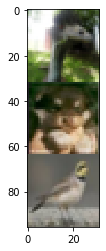

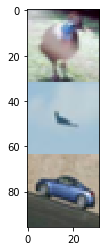

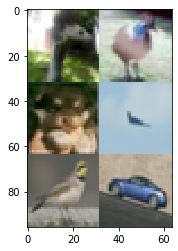

torch.Size([3, 96, 32])


In [7]:
img1 = torch.cat((background_data[0],background_data[1],background_data[2]),1)
imshow(img1)
img2 = torch.cat((background_data[27],background_data[3],background_data[43]),1)
imshow(img2)
img3 = torch.cat((img1,img2),2)
imshow(img3)
print(img2.size())


In [8]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]].type("torch.DoubleTensor"))
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx].type("torch.DoubleTensor"))
      label = foreground_label[fg_idx]-7  # minus 7 because our fore ground classes are 7,8,9 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [9]:
desired_num = 30000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(desired_num):
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)



7


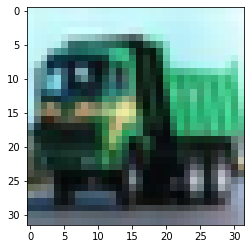

truck


In [10]:
qw=45

print(fore_idx[qw])
imshow(mosaic_list_of_images[qw][fore_idx[qw]])
# print(mosaic_list_of_images[0])
print(classes[mosaic_label[qw]+7]) # add 7 as we had subtracted 7 while saving

# imshow(mosaic_list_of_images[13][2])
# print(type(mosaic_list_of_images[1][0]))
# print(mosaic_label)

In [11]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list_of_images, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class Module1(nn.Module):
  def __init__(self):
    super(Module1, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,1)

  def forward(self, z):
    x = torch.zeros([batch,9],dtype=torch.float64)
    y = torch.zeros([batch,3, 32,32], dtype=torch.float64)
    x,y = x.to("cuda"),y.to("cuda")
    for i in range(9):
      x[:,i] = self.helper(z[:,i])[:,0]
    x = F.softmax(x,dim=1)   # alphas
    
    x1 = x[:,0]
    torch.mul(x1[:,None,None,None],z[:,0])

    for i in range(9):            
      x1 = x[:,i]          
      y = y + torch.mul(x1[:,None,None,None],z[:,i])
    return y , x 
  
  def helper(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x
      


In [13]:
 class Module2(nn.Module):
  def __init__(self):
    super(Module2, self).__init__()
    
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,3)

  def forward(self,y):  #z batch of list of 9 images
    y1 = self.pool(F.relu(self.conv1(y)))
    y1 = self.pool(F.relu(self.conv2(y1)))
    y1 = y1.view(-1, 16 * 5 * 5)

    y1 = F.relu(self.fc1(y1))
    y1 = F.relu(self.fc2(y1))
    y1 = F.relu(self.fc3(y1))
    y1 = self.fc4(y1)
    return y1 


In [14]:
where_net = Module1().double()
where_net = where_net.to("cuda")
# print(net.parameters)

In [15]:
# idx = np.random.randint(0,250,10)
# train_iter = iter(train_loader)
# images,labels,_=train_iter.next()

# for i in idx:
#   imshow(where_net1(images)[i].detach().numpy())

In [16]:
what_net = Module2().double()
what_net = what_net.to("cuda")

In [17]:
# where_net.load_state_dict(torch.load("model_epoch90.pt"))
# what_net.load_state_dict(torch.load("model_epoch90.pt"))
# print(fore_net.parameters)

In [18]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx_test.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  test_images.append(image_list)
  test_label.append(label)

In [19]:
test_data = MosaicDataset(test_images,test_label,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [20]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer_where = optim.SGD(where_net.parameters(), lr=0.01, momentum=0.9)
optimizer_what = optim.SGD(what_net.parameters(), lr=0.01, momentum=0.9)

nos_epochs = 200
every_what_epoch = 10

train_loss=[]
test_loss =[]
train_acc = []
test_acc = []
for epoch in range(nos_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    batch_correct = 0.0
    cnt=0
    total=0
    iteration = desired_num // batch
    #training data set
  
    if (epoch % (every_what_epoch*2) ) < every_what_epoch :
        print(epoch,"updating what_net, where_net is freezed")
    elif (epoch % (every_what_epoch*2)) > every_what_epoch :
        print(epoch,"updating where_net, what_net is freezed")
      
    for i, data in  enumerate(train_loader):
        inputs , labels , fore_idx = data
        inputs,labels = inputs.to("cuda"),labels.to("cuda") 
        # zero the parameter gradients
        
        optimizer_what.zero_grad()
        optimizer_where.zero_grad()
        
        avg_images , alphas = where_net(inputs)
        outputs = what_net(avg_images)
        
        _, predicted = torch.max(outputs.data, 1)
        

        loss = criterion(outputs, labels) 
        loss.backward() 
    
        if (epoch % (every_what_epoch*2) ) < every_what_epoch :
            optimizer_what.step()
        elif (epoch % (every_what_epoch*2)) > every_what_epoch :
            optimizer_where.step()
        batch_correct += sum(predicted == labels)
        total += len(predicted)
        running_loss += loss.item()
        if cnt % 120 == 119:    # print every 40 mini-batches
            print("--"*40)
            print("Epoch: ",epoch)
#             print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / 120))
            train_loss.append(running_loss/120)
            train_acc.append(batch_correct.item()/desired_num)
            print("total_Correct:",batch_correct.item(),"Total:",total,"train_loss",running_loss/120,"train_acc: ", batch_correct.item()/total)
            #running_loss = 0.0
        cnt=cnt+1
   
    with torch.no_grad():
      loss = 0.0
      correct = 0.0
      tot =0
      for data in test_loader:
        inputs, labels , fore_idx = data
        inputs,labels = inputs.to("cuda"),labels.to("cuda") 
        avg_images , alphas = where_net(inputs)
        outputs = what_net(avg_images)
        _, predicted = torch.max(outputs.data, 1)
        loss += criterion(outputs, labels).item() 
        correct += sum(predicted == labels)
        tot += len(predicted)

      test_loss.append(loss/40) # 10000/250 = 40
      test_acc.append(correct.item()/tot)
      print("total_Correct:",correct.item(),"Total:",tot,"test loss: ", loss/40, "test accuracy", correct.item()/tot)
    
    if (epoch % (every_what_epoch*2) == every_what_epoch*2 - 1):
        torch.save(where_net.state_dict(),"weights2/where_model_epoch"+str(epoch)+".pt")
        torch.save(what_net.state_dict(),"weights2/what_model_epoch"+str(epoch)+".pt")
    
print('Finished Training')
torch.save(where_net.state_dict(),"weights2/where_model_epoch"+str(nos_epochs)+".pt")
torch.save(what_net.state_dict(),"weights2/what_model_epoch"+str(nos_epochs)+".pt")

0 updating what_net, where_net is freezed
--------------------------------------------------------------------------------
Epoch:  0
total_Correct: 10079.0 Total: 30000 train_loss 1.0989646511652038 train_acc:  0.3359666666666667
total_Correct: 3371.0 Total: 10000 test loss:  1.0985615389842691 test accuracy 0.3371
1 updating what_net, where_net is freezed
--------------------------------------------------------------------------------
Epoch:  1
total_Correct: 10084.0 Total: 30000 train_loss 1.0985931849756772 train_acc:  0.33613333333333334
total_Correct: 3371.0 Total: 10000 test loss:  1.098471526992659 test accuracy 0.3371
2 updating what_net, where_net is freezed
--------------------------------------------------------------------------------
Epoch:  2
total_Correct: 10079.0 Total: 30000 train_loss 1.0985137557942508 train_acc:  0.3359666666666667
total_Correct: 3315.0 Total: 10000 test loss:  1.098426409267929 test accuracy 0.3315
3 updating what_net, where_net is freezed
--------

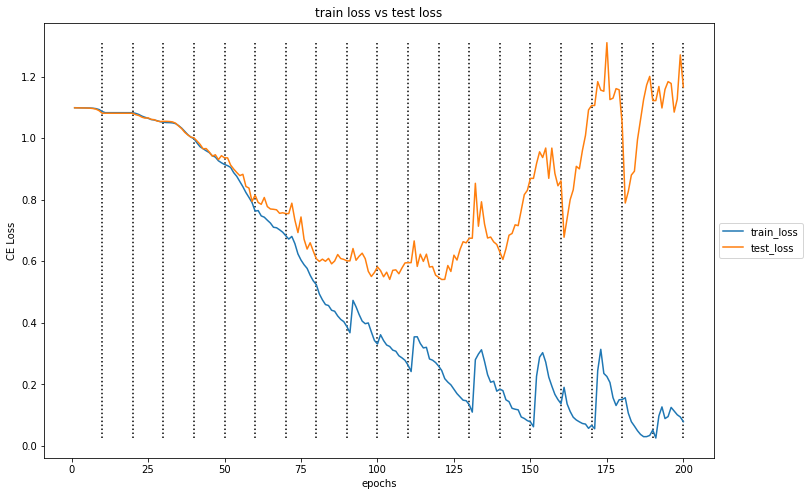

In [21]:
fig = plt.figure(figsize = (12,8) )
vline_list = np.arange(every_what_epoch, nos_epochs + every_what_epoch, every_what_epoch )
# train_loss = np.random.randn(340)
# test_loss = np.random.randn(340)
epoch_list = np.arange(1, nos_epochs+1)
plt.plot(epoch_list,train_loss, label='train_loss')
plt.plot(epoch_list,test_loss, label='test_loss')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("CE Loss")
plt.vlines(vline_list,min(min(train_loss),min(test_loss)), max(max(test_loss),max(train_loss)),linestyles='dotted')
plt.title("train loss vs test loss")
plt.show()
fig.savefig("train_test_loss_plot.pdf")


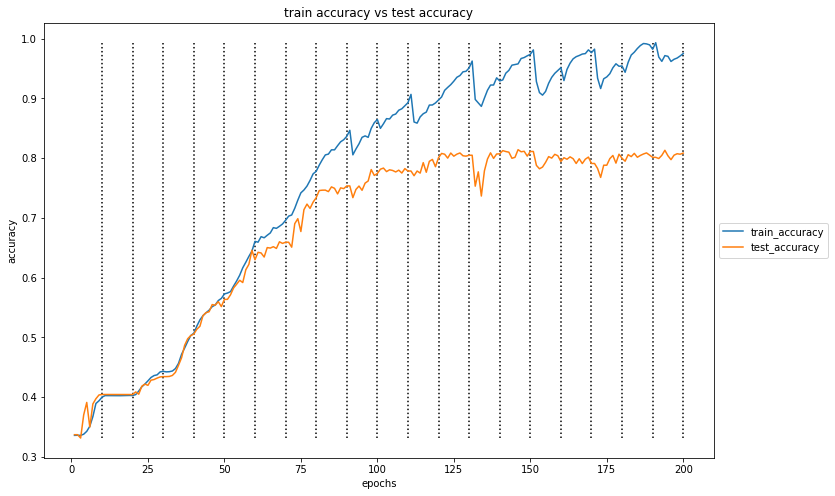

In [22]:
fig = plt.figure(figsize = (12,8) )
vline_list = np.arange(every_what_epoch, nos_epochs + every_what_epoch, every_what_epoch )
# train_acc = np.random.randn(340)
# test_acc = np.random.randn(340)
epoch_list = np.arange(1, nos_epochs+1)
plt.plot(epoch_list,train_acc, label='train_accuracy')
plt.plot(epoch_list,test_acc, label='test_accuracy')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.vlines(vline_list,min(min(train_acc),min(test_acc)), max(max(test_acc),max(train_acc)),linestyles='dotted')
plt.title("train accuracy vs test accuracy")
plt.show()
fig.savefig("train_test_acc_plot.pdf")

In [23]:
def display(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

****************************************************************************************************


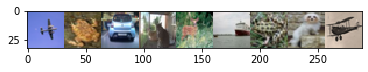

tensor([0.0035, 0.0342, 0.0370, 0.1239, 0.0105, 0.4680, 0.0536, 0.1099, 0.1593],
       device='cuda:0', dtype=torch.float64)


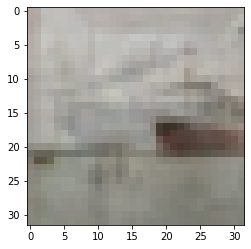

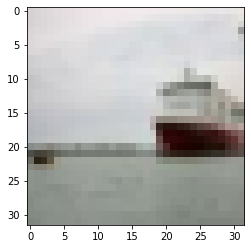

predicted ship
true ship
****************************************************************************************************


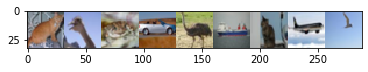

tensor([0.0239, 0.0015, 0.0149, 0.0297, 0.0045, 0.9110, 0.0115, 0.0011, 0.0019],
       device='cuda:0', dtype=torch.float64)


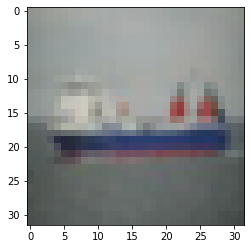

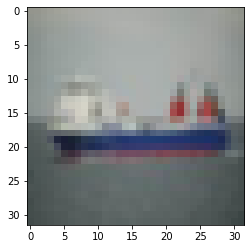

predicted ship
true ship
****************************************************************************************************


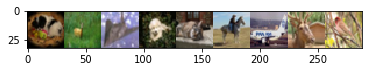

tensor([0.0034, 0.0076, 0.0232, 0.0183, 0.0840, 0.5203, 0.3198, 0.0211, 0.0023],
       device='cuda:0', dtype=torch.float64)


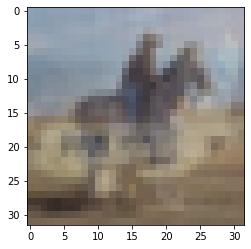

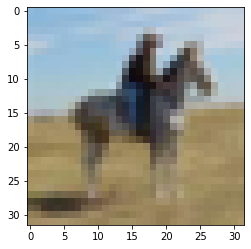

predicted horse
true horse
****************************************************************************************************


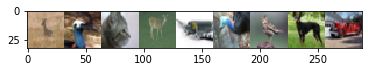

tensor([0.0162, 0.0599, 0.1306, 0.0264, 0.1195, 0.0587, 0.0670, 0.0469, 0.4748],
       device='cuda:0', dtype=torch.float64)


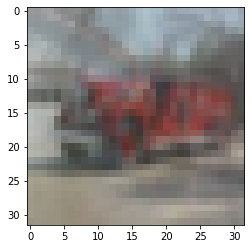

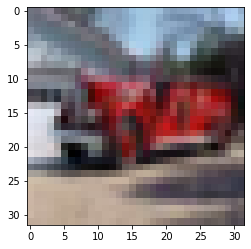

predicted truck
true truck
****************************************************************************************************


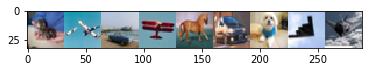

tensor([7.3743e-03, 5.7928e-04, 9.8480e-03, 3.1583e-04, 9.7277e-01, 4.0563e-03,
        2.7789e-03, 9.7443e-04, 1.3011e-03], device='cuda:0',
       dtype=torch.float64)


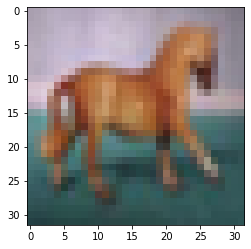

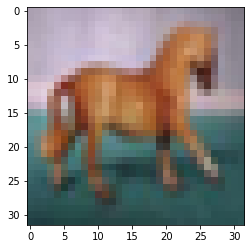

predicted horse
true horse
****************************************************************************************************


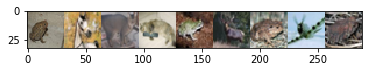

tensor([0.1335, 0.0551, 0.4129, 0.0834, 0.0185, 0.1420, 0.0103, 0.0087, 0.1355],
       device='cuda:0', dtype=torch.float64)


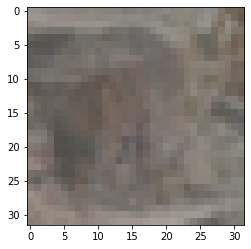

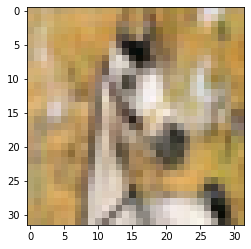

predicted horse
true horse
****************************************************************************************************


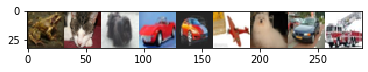

tensor([2.2165e-03, 3.3865e-03, 2.9273e-02, 5.8031e-03, 6.3391e-04, 3.9906e-03,
        7.5650e-03, 4.7863e-02, 8.9927e-01], device='cuda:0',
       dtype=torch.float64)


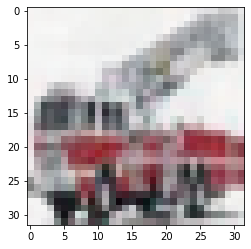

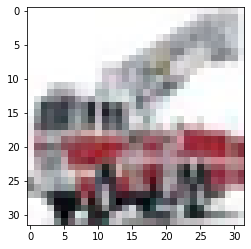

predicted truck
true truck
****************************************************************************************************


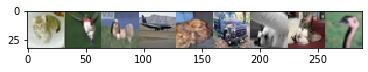

tensor([0.0011, 0.0149, 0.8082, 0.0398, 0.0580, 0.0660, 0.0052, 0.0023, 0.0046],
       device='cuda:0', dtype=torch.float64)


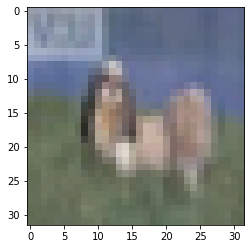

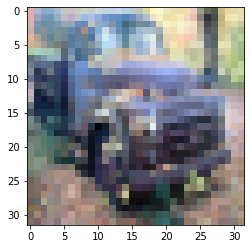

predicted truck
true truck
****************************************************************************************************


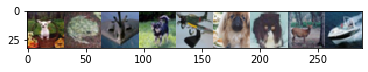

tensor([5.2588e-04, 6.9628e-03, 4.6629e-02, 1.3181e-03, 2.9221e-03, 3.0343e-03,
        6.1886e-03, 1.0554e-02, 9.2187e-01], device='cuda:0',
       dtype=torch.float64)


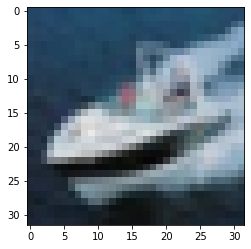

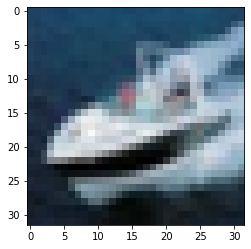

predicted ship
true ship
****************************************************************************************************


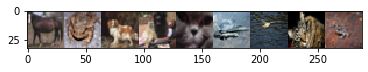

tensor([0.6995, 0.0085, 0.0070, 0.0096, 0.0070, 0.2301, 0.0121, 0.0092, 0.0170],
       device='cuda:0', dtype=torch.float64)


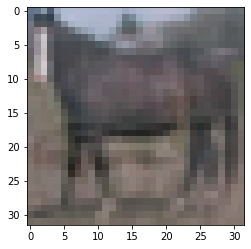

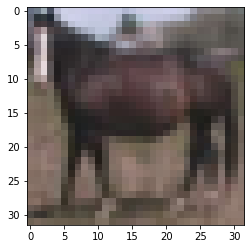

predicted horse
true horse
****************************************************************************************************


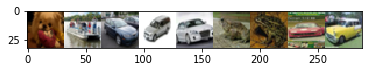

tensor([0.0049, 0.8909, 0.0053, 0.0014, 0.0024, 0.0191, 0.0060, 0.0302, 0.0399],
       device='cuda:0', dtype=torch.float64)


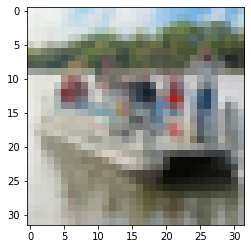

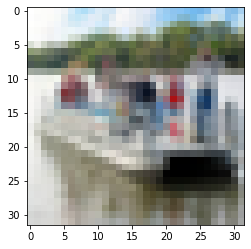

predicted ship
true ship
****************************************************************************************************


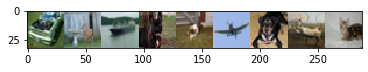

tensor([4.3024e-02, 1.4370e-01, 4.1382e-01, 1.8872e-02, 2.9212e-02, 3.7610e-04,
        6.0968e-03, 3.1754e-01, 2.7359e-02], device='cuda:0',
       dtype=torch.float64)


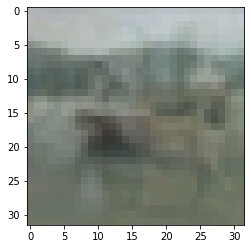

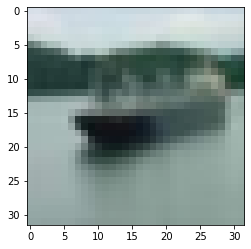

predicted ship
true ship
****************************************************************************************************


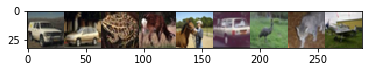

tensor([0.0655, 0.0093, 0.0251, 0.0259, 0.7069, 0.0113, 0.0148, 0.0082, 0.1330],
       device='cuda:0', dtype=torch.float64)


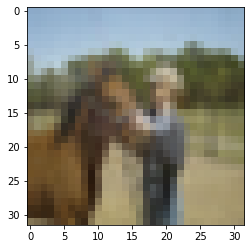

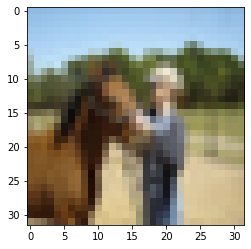

predicted horse
true horse
****************************************************************************************************


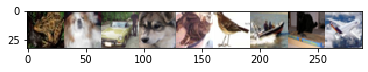

tensor([9.5198e-02, 1.6061e-02, 1.8666e-01, 4.1682e-02, 4.5919e-03, 4.4305e-04,
        6.1199e-01, 2.1069e-02, 2.2300e-02], device='cuda:0',
       dtype=torch.float64)


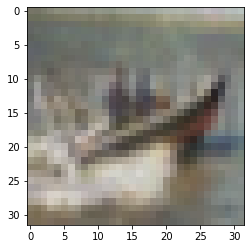

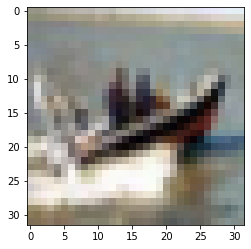

predicted ship
true ship
****************************************************************************************************


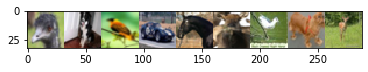

tensor([0.1158, 0.1214, 0.0058, 0.0394, 0.1986, 0.2193, 0.0548, 0.2246, 0.0202],
       device='cuda:0', dtype=torch.float64)


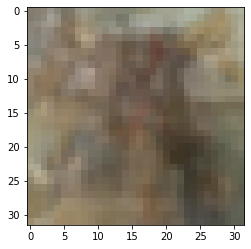

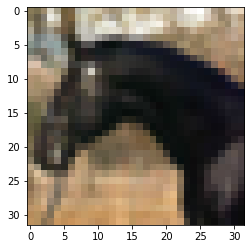

predicted horse
true horse
****************************************************************************************************


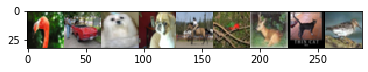

tensor([0.0071, 0.0153, 0.0097, 0.0041, 0.9004, 0.0082, 0.0030, 0.0298, 0.0225],
       device='cuda:0', dtype=torch.float64)


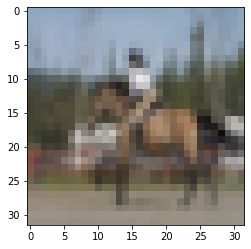

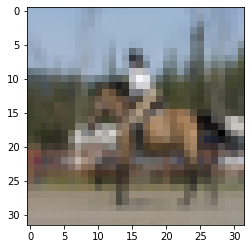

predicted horse
true horse
****************************************************************************************************


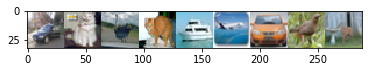

tensor([0.0706, 0.0437, 0.1681, 0.0091, 0.3389, 0.0166, 0.0321, 0.0037, 0.3172],
       device='cuda:0', dtype=torch.float64)


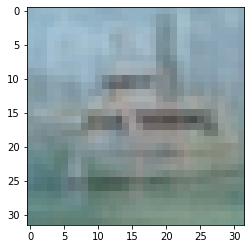

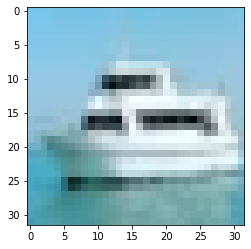

predicted ship
true ship
****************************************************************************************************


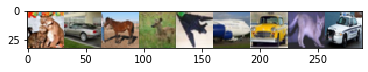

tensor([0.0076, 0.0031, 0.9287, 0.0027, 0.0012, 0.0209, 0.0052, 0.0288, 0.0017],
       device='cuda:0', dtype=torch.float64)


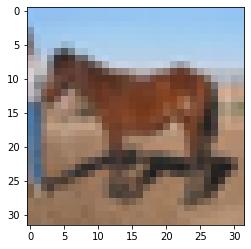

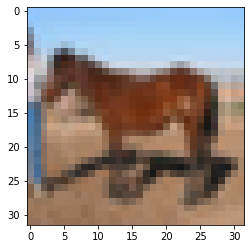

predicted horse
true horse
****************************************************************************************************


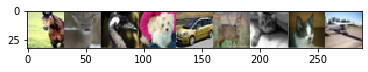

tensor([0.0385, 0.3656, 0.0941, 0.0217, 0.0100, 0.1046, 0.0867, 0.0158, 0.2629],
       device='cuda:0', dtype=torch.float64)


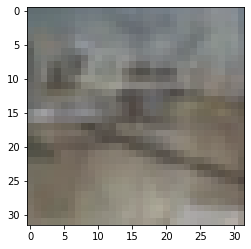

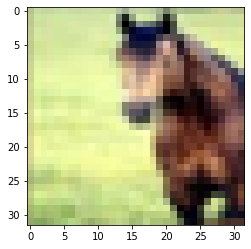

predicted horse
true horse
****************************************************************************************************


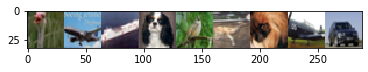

tensor([0.0153, 0.0881, 0.6678, 0.0019, 0.0048, 0.0673, 0.0083, 0.1131, 0.0333],
       device='cuda:0', dtype=torch.float64)


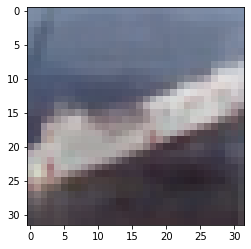

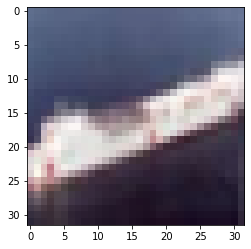

predicted ship
true ship
****************************************************************************************************


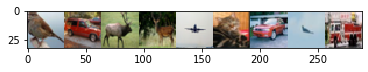

tensor([1.0936e-03, 7.0538e-02, 3.4445e-04, 3.0369e-02, 2.9286e-02, 3.5601e-03,
        1.8969e-02, 1.2542e-02, 8.3330e-01], device='cuda:0',
       dtype=torch.float64)


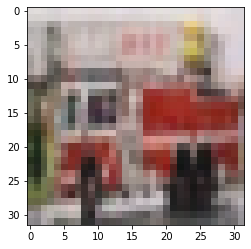

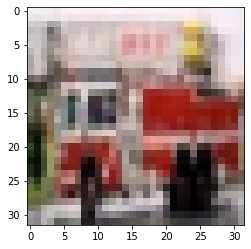

predicted truck
true truck
****************************************************************************************************


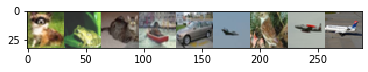

tensor([0.0081, 0.0284, 0.0599, 0.1027, 0.2861, 0.2627, 0.0215, 0.1389, 0.0915],
       device='cuda:0', dtype=torch.float64)


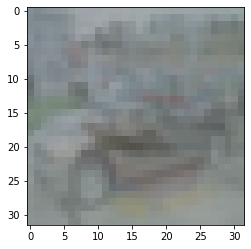

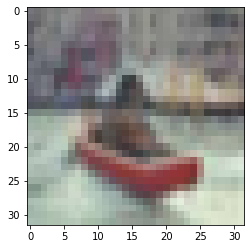

predicted ship
true ship
****************************************************************************************************


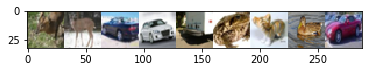

tensor([0.0255, 0.0208, 0.2060, 0.0014, 0.6163, 0.0294, 0.0047, 0.0671, 0.0288],
       device='cuda:0', dtype=torch.float64)


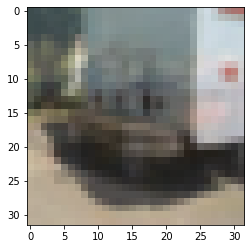

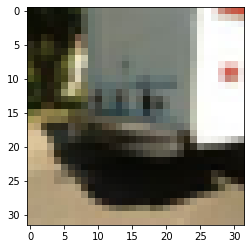

predicted truck
true truck
****************************************************************************************************


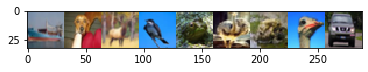

tensor([5.3802e-01, 2.9339e-03, 9.3087e-03, 2.4330e-05, 3.9302e-02, 1.2654e-01,
        2.9478e-02, 8.4349e-05, 2.5431e-01], device='cuda:0',
       dtype=torch.float64)


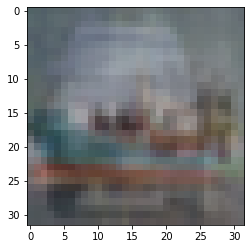

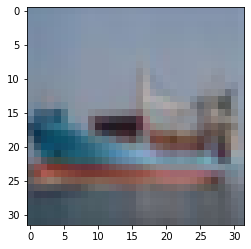

predicted ship
true ship
****************************************************************************************************


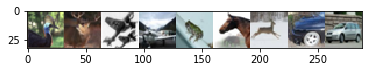

tensor([0.0304, 0.0809, 0.0067, 0.1521, 0.0063, 0.5679, 0.0263, 0.0724, 0.0569],
       device='cuda:0', dtype=torch.float64)


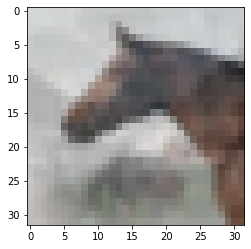

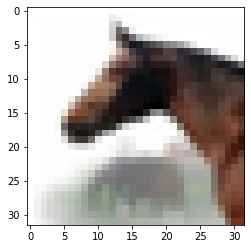

predicted horse
true horse
****************************************************************************************************


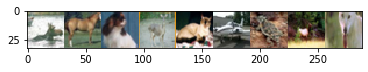

tensor([0.0946, 0.5027, 0.0129, 0.0210, 0.0164, 0.1964, 0.0244, 0.0039, 0.1277],
       device='cuda:0', dtype=torch.float64)


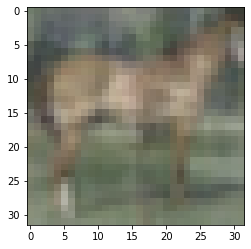

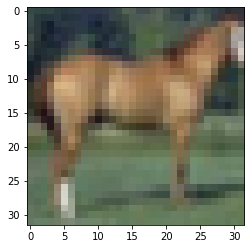

predicted horse
true horse
****************************************************************************************************


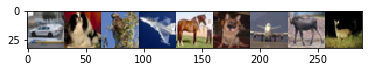

tensor([0.0338, 0.0011, 0.0034, 0.0050, 0.8485, 0.0049, 0.0236, 0.0687, 0.0110],
       device='cuda:0', dtype=torch.float64)


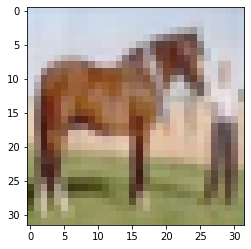

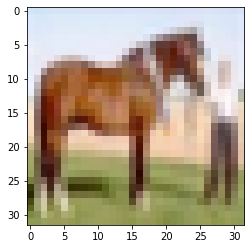

predicted horse
true horse
****************************************************************************************************


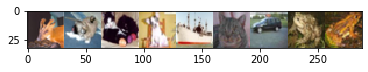

tensor([0.0040, 0.0090, 0.0165, 0.0023, 0.6556, 0.1406, 0.1603, 0.0087, 0.0030],
       device='cuda:0', dtype=torch.float64)


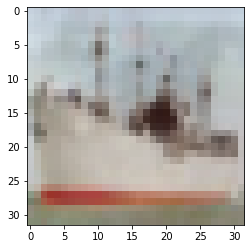

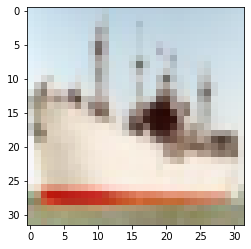

predicted ship
true ship
****************************************************************************************************


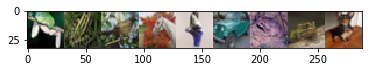

tensor([0.0107, 0.0223, 0.0676, 0.6654, 0.0015, 0.0628, 0.0492, 0.0565, 0.0640],
       device='cuda:0', dtype=torch.float64)


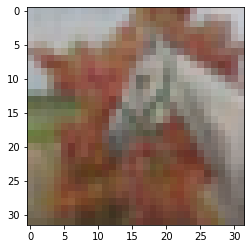

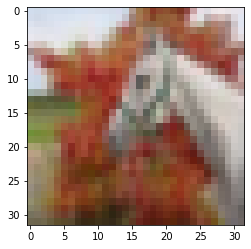

predicted horse
true horse
****************************************************************************************************


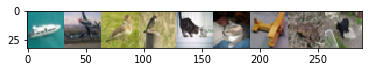

tensor([0.8200, 0.0994, 0.0017, 0.0010, 0.0021, 0.0068, 0.0172, 0.0188, 0.0330],
       device='cuda:0', dtype=torch.float64)


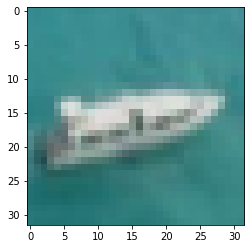

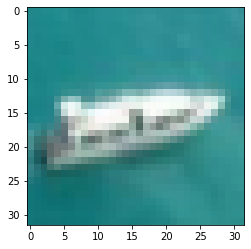

predicted ship
true ship
****************************************************************************************************


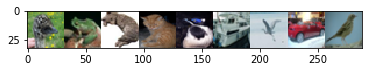

tensor([0.0213, 0.0041, 0.1098, 0.0808, 0.0791, 0.6273, 0.0143, 0.0365, 0.0268],
       device='cuda:0', dtype=torch.float64)


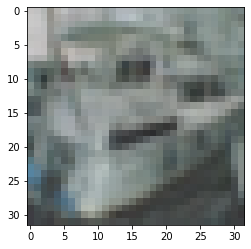

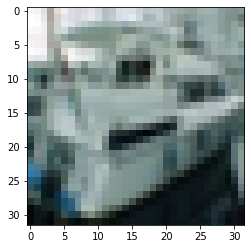

predicted ship
true ship
****************************************************************************************************


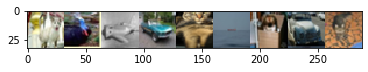

tensor([0.0115, 0.0482, 0.1073, 0.0169, 0.0052, 0.6940, 0.0039, 0.0752, 0.0377],
       device='cuda:0', dtype=torch.float64)


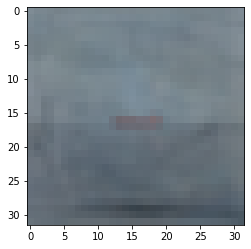

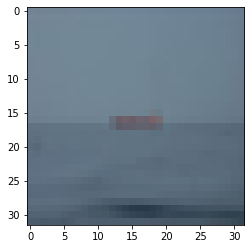

predicted ship
true ship
****************************************************************************************************


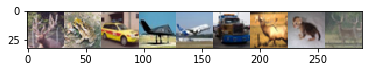

tensor([0.0304, 0.0093, 0.0285, 0.0045, 0.0130, 0.8310, 0.0026, 0.0215, 0.0592],
       device='cuda:0', dtype=torch.float64)


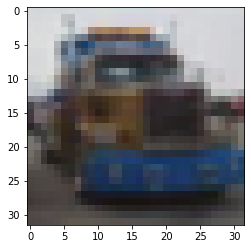

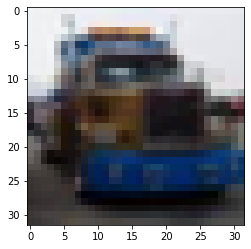

predicted truck
true truck
****************************************************************************************************


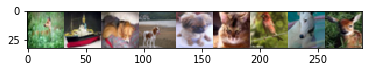

tensor([0.0148, 0.8000, 0.0289, 0.0284, 0.0016, 0.0712, 0.0028, 0.0499, 0.0024],
       device='cuda:0', dtype=torch.float64)


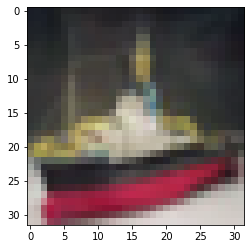

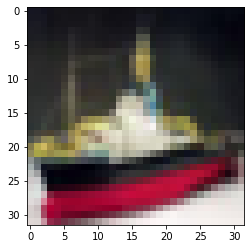

predicted ship
true ship
****************************************************************************************************


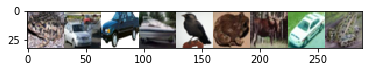

tensor([9.1977e-02, 1.5492e-01, 2.0797e-02, 6.1176e-01, 1.7023e-02, 7.8560e-03,
        6.1916e-02, 6.0889e-04, 3.3145e-02], device='cuda:0',
       dtype=torch.float64)


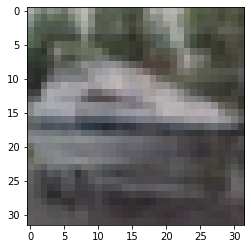

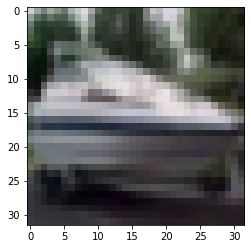

predicted ship
true ship
****************************************************************************************************


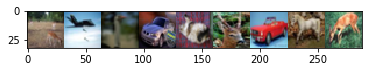

tensor([0.1014, 0.0060, 0.0914, 0.0052, 0.0492, 0.0130, 0.0142, 0.6998, 0.0198],
       device='cuda:0', dtype=torch.float64)


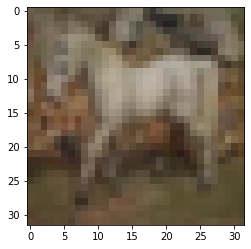

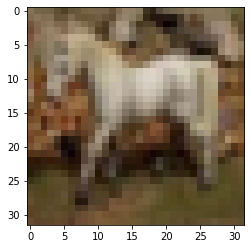

predicted horse
true horse
****************************************************************************************************


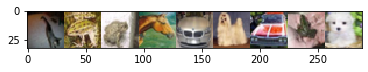

tensor([0.0463, 0.0029, 0.0722, 0.7600, 0.0144, 0.0774, 0.0088, 0.0099, 0.0082],
       device='cuda:0', dtype=torch.float64)


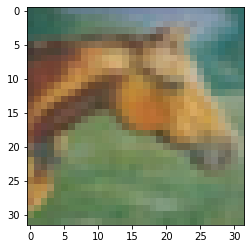

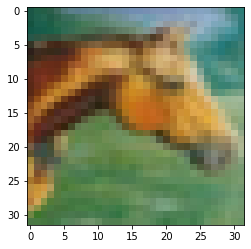

predicted horse
true horse
****************************************************************************************************


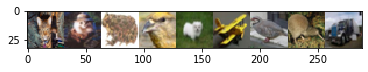

tensor([0.0010, 0.0068, 0.0068, 0.0017, 0.0057, 0.0015, 0.0199, 0.0040, 0.9526],
       device='cuda:0', dtype=torch.float64)


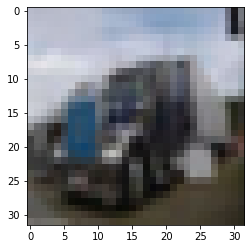

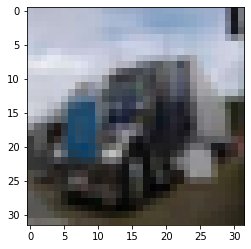

predicted truck
true truck
****************************************************************************************************


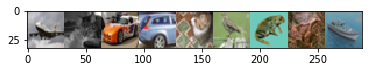

tensor([0.1902, 0.0652, 0.0042, 0.0570, 0.0383, 0.0036, 0.0927, 0.0577, 0.4910],
       device='cuda:0', dtype=torch.float64)


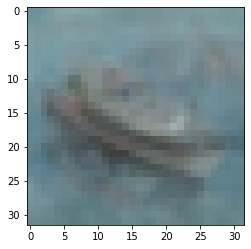

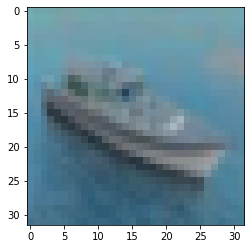

predicted ship
true ship
****************************************************************************************************


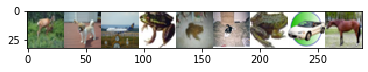

tensor([1.6827e-02, 6.3449e-02, 1.3502e-02, 2.2882e-02, 1.3469e-02, 2.3520e-02,
        3.3188e-02, 5.5698e-04, 8.1261e-01], device='cuda:0',
       dtype=torch.float64)


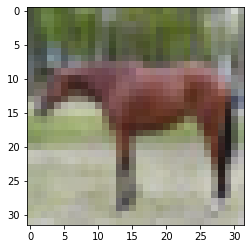

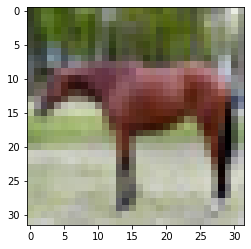

predicted horse
true horse
****************************************************************************************************


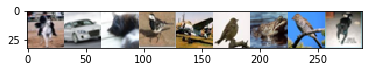

tensor([9.7439e-01, 2.0512e-03, 1.5214e-03, 5.9906e-03, 1.3667e-02, 6.0573e-04,
        1.4070e-03, 3.4193e-06, 3.6744e-04], device='cuda:0',
       dtype=torch.float64)


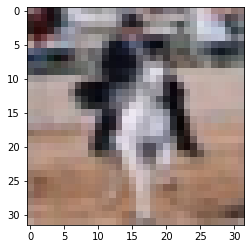

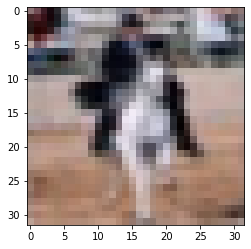

predicted horse
true horse
****************************************************************************************************


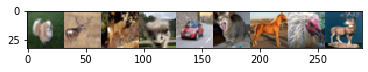

tensor([0.0052, 0.0256, 0.0163, 0.0666, 0.0181, 0.0191, 0.2775, 0.5487, 0.0228],
       device='cuda:0', dtype=torch.float64)


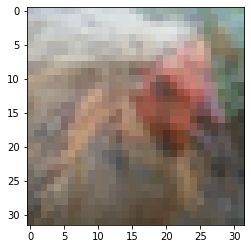

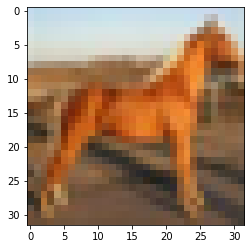

predicted horse
true horse
****************************************************************************************************


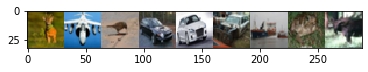

tensor([1.0745e-02, 8.1171e-04, 6.1700e-03, 2.8345e-02, 1.8303e-03, 1.6871e-02,
        8.5379e-01, 3.0310e-02, 5.1129e-02], device='cuda:0',
       dtype=torch.float64)


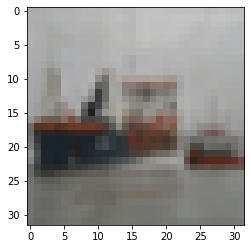

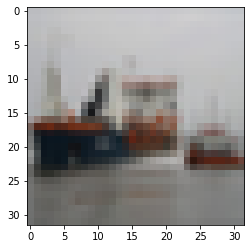

predicted ship
true ship
****************************************************************************************************


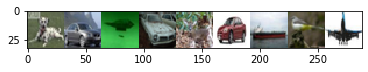

tensor([5.6204e-03, 1.3421e-02, 1.6053e-03, 5.2365e-03, 5.5654e-03, 2.4866e-05,
        9.5732e-01, 1.0610e-02, 6.0035e-04], device='cuda:0',
       dtype=torch.float64)


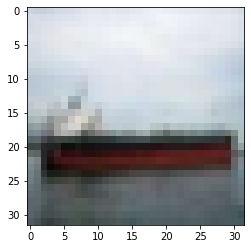

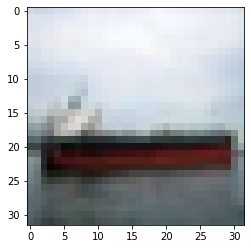

predicted ship
true ship
****************************************************************************************************


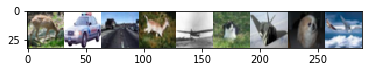

tensor([0.0150, 0.0104, 0.7205, 0.0037, 0.0464, 0.0399, 0.1367, 0.0051, 0.0225],
       device='cuda:0', dtype=torch.float64)


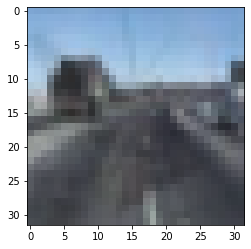

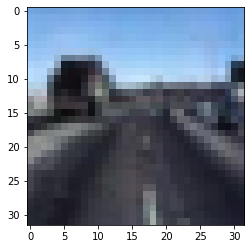

predicted truck
true truck
****************************************************************************************************


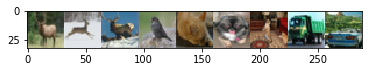

tensor([0.0072, 0.0073, 0.0429, 0.0050, 0.0161, 0.0416, 0.0071, 0.5546, 0.3182],
       device='cuda:0', dtype=torch.float64)


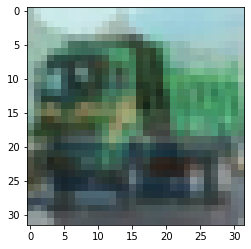

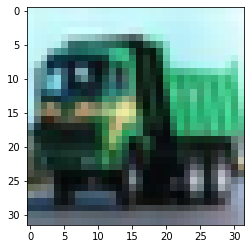

predicted truck
true truck
****************************************************************************************************


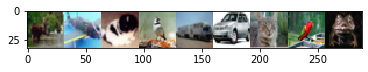

tensor([1.5044e-02, 6.3760e-02, 1.6500e-02, 1.7730e-02, 8.3198e-01, 1.6324e-02,
        2.4570e-02, 8.2503e-04, 1.3263e-02], device='cuda:0',
       dtype=torch.float64)


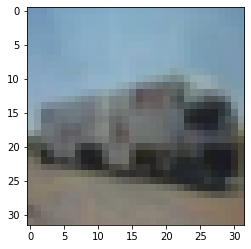

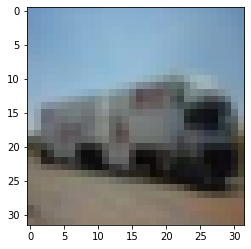

predicted truck
true truck
****************************************************************************************************


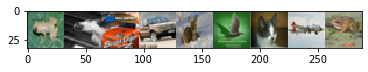

tensor([0.0578, 0.0608, 0.3666, 0.0493, 0.1527, 0.0579, 0.0241, 0.0313, 0.1995],
       device='cuda:0', dtype=torch.float64)


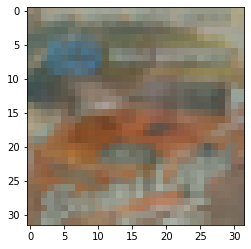

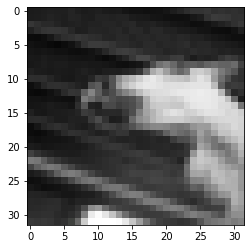

predicted horse
true horse
****************************************************************************************************


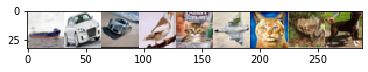

tensor([0.8231, 0.0029, 0.0300, 0.0398, 0.0248, 0.0302, 0.0107, 0.0053, 0.0333],
       device='cuda:0', dtype=torch.float64)


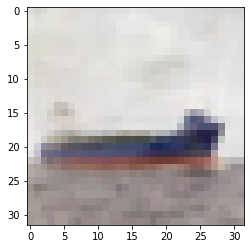

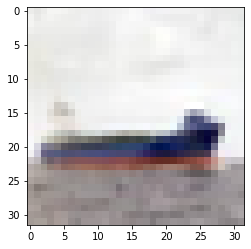

predicted ship
true ship
****************************************************************************************************


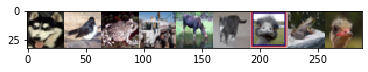

tensor([0.0231, 0.0359, 0.0223, 0.6416, 0.0483, 0.0236, 0.0514, 0.1374, 0.0164],
       device='cuda:0', dtype=torch.float64)


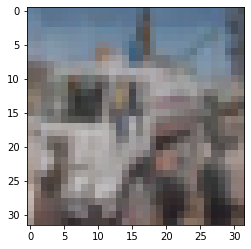

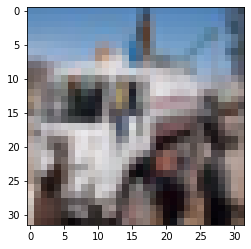

predicted truck
true truck
Accuracy of the network on the 30000 train images: 97 %
total correct 29328
total train set images 30000
focus_true_pred_true 43
focus_false_pred_true 7
focus_true_pred_false 0
focus_false_pred_false 0
argmax_more_than_half 40
argmax_less_than_half 10


In [24]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

train_loader1 = DataLoader( msd,batch_size= batch ,shuffle=False)
with torch.no_grad():
  for data in train_loader1:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    if flag==1 :
      for j in range (50):
        print("*"*100)
        img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
        display(img1.cpu())

        print(alphas[j])

        img2 = avg_images[j]
        display(img2.cpu())

        img3 = inputs[j][fore_idx[j]]
        display(img3.cpu())

        print("predicted", classes[predicted[j]+7])
        print("true", classes[labels[j]+7])
        
        focus = torch.argmax(alphas[j])
      
        if(alphas[j][focus] >= 0.5):
          argmax_more_than_half +=1
        else:
          argmax_less_than_half +=1

        if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1

        elif(focus != fore_idx[j] and predicted[j] == labels[j]):
          focus_false_pred_true +=1

        elif(focus == fore_idx[j] and predicted[j] != labels[j]):
          focus_true_pred_false +=1

        elif(focus != fore_idx[j] and predicted[j] != labels[j]):
          focus_false_pred_false +=1

      flag =0

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

In [25]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
    bg_idx = np.random.randint(0,35000,8)
    fg_idx = np.random.randint(0,15000)
    fg = np.random.randint(0,9)
    fore_idx_test.append(fg)
    image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
    test_images.append(image_list)
    test_label.append(label)

In [26]:
# test_data = MosaicDataset(test_images,test_label,)
# test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

8


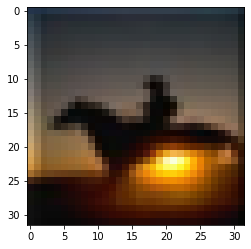

horse


In [27]:
print(fore_idx_test[0])
imshow(test_images[0][fore_idx_test[0]])
print(classes[test_label[0]+7])

****************************************************************************************************


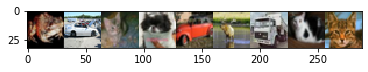

tensor([0.0206, 0.1252, 0.0579, 0.0331, 0.0280, 0.0093, 0.5816, 0.0710, 0.0733],
       device='cuda:0', dtype=torch.float64)


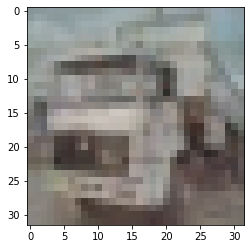

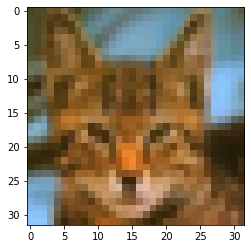

predicted truck
true truck
****************************************************************************************************


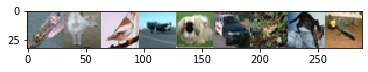

tensor([0.1509, 0.1974, 0.1819, 0.1729, 0.0994, 0.1203, 0.0259, 0.0305, 0.0209],
       device='cuda:0', dtype=torch.float64)


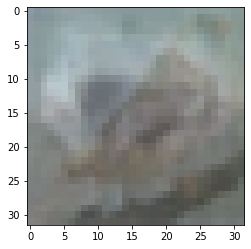

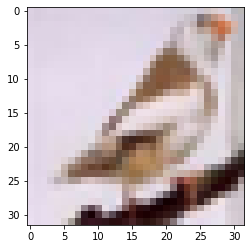

predicted ship
true ship
****************************************************************************************************


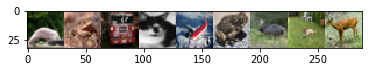

tensor([0.0235, 0.0400, 0.3594, 0.2449, 0.0397, 0.0213, 0.1695, 0.0357, 0.0660],
       device='cuda:0', dtype=torch.float64)


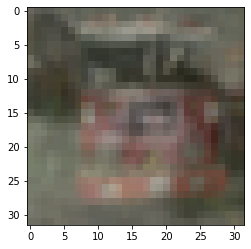

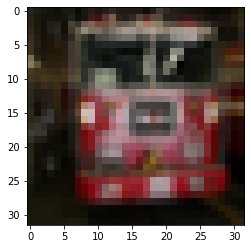

predicted horse
true truck
****************************************************************************************************


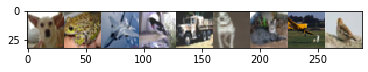

tensor([0.0701, 0.0191, 0.0174, 0.0374, 0.4689, 0.0133, 0.2002, 0.1515, 0.0221],
       device='cuda:0', dtype=torch.float64)


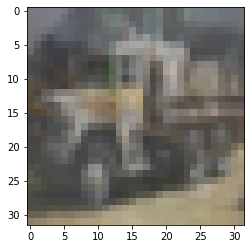

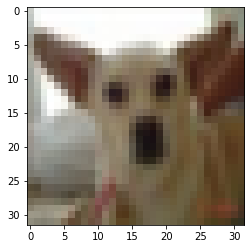

predicted truck
true truck
****************************************************************************************************


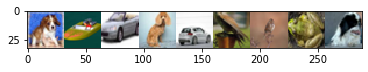

tensor([4.3995e-03, 9.3326e-01, 5.2393e-04, 1.0814e-03, 1.2408e-02, 7.1739e-03,
        2.1532e-02, 2.5159e-03, 1.7102e-02], device='cuda:0',
       dtype=torch.float64)


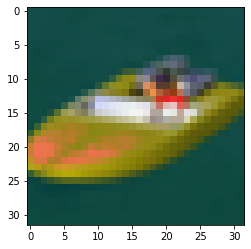

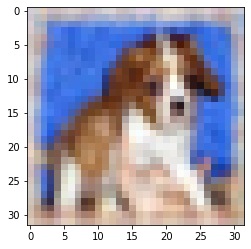

predicted ship
true ship
****************************************************************************************************


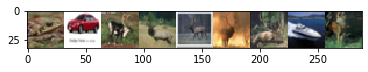

tensor([0.0481, 0.0265, 0.0360, 0.0160, 0.2425, 0.0255, 0.0901, 0.4715, 0.0438],
       device='cuda:0', dtype=torch.float64)


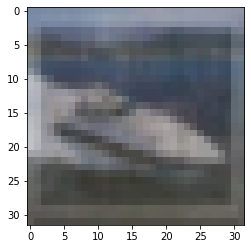

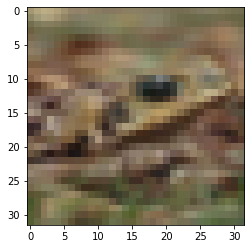

predicted ship
true ship
****************************************************************************************************


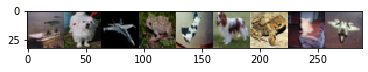

tensor([0.1345, 0.0229, 0.0513, 0.0888, 0.3545, 0.1034, 0.0006, 0.0682, 0.1758],
       device='cuda:0', dtype=torch.float64)


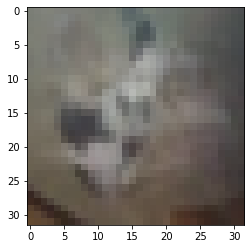

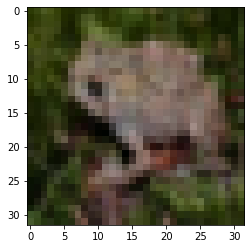

predicted horse
true ship
****************************************************************************************************


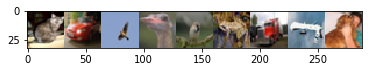

tensor([4.1365e-04, 7.4720e-03, 2.7527e-04, 1.8708e-02, 9.1183e-04, 1.0812e-03,
        9.6241e-01, 7.0974e-03, 1.6286e-03], device='cuda:0',
       dtype=torch.float64)


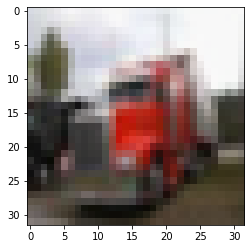

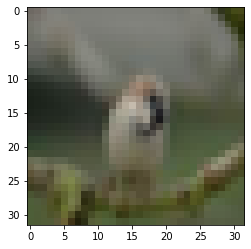

predicted truck
true truck
****************************************************************************************************


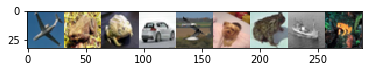

tensor([0.0038, 0.0100, 0.1401, 0.0048, 0.1652, 0.0301, 0.0413, 0.5926, 0.0122],
       device='cuda:0', dtype=torch.float64)


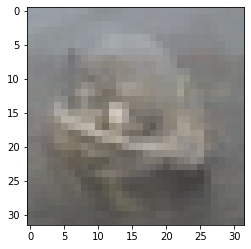

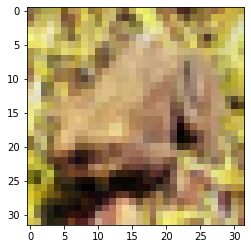

predicted ship
true ship
****************************************************************************************************


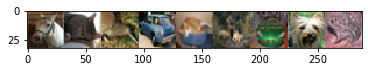

tensor([0.0358, 0.3245, 0.0338, 0.0721, 0.1362, 0.1046, 0.1076, 0.1176, 0.0678],
       device='cuda:0', dtype=torch.float64)


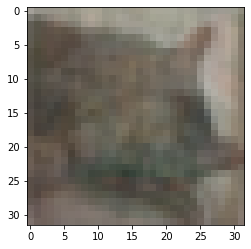

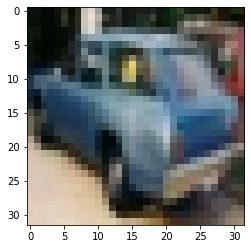

predicted horse
true horse
****************************************************************************************************


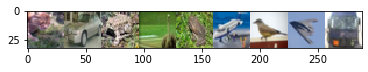

tensor([2.3723e-02, 1.5341e-04, 1.9184e-03, 3.7771e-03, 1.8106e-03, 4.5911e-02,
        4.4300e-02, 2.3089e-03, 8.7610e-01], device='cuda:0',
       dtype=torch.float64)


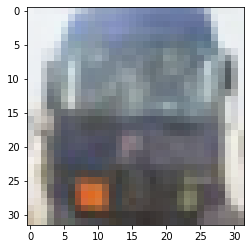

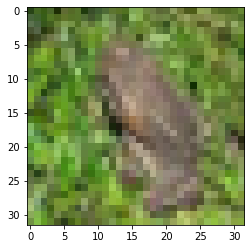

predicted truck
true truck
****************************************************************************************************


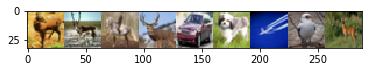

tensor([0.0071, 0.2163, 0.5447, 0.1015, 0.0016, 0.0692, 0.0035, 0.0348, 0.0212],
       device='cuda:0', dtype=torch.float64)


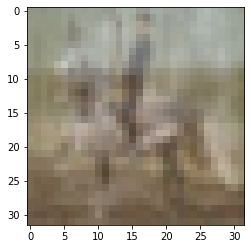

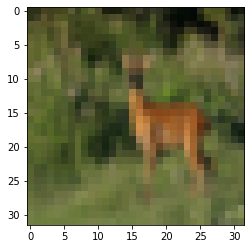

predicted horse
true horse
****************************************************************************************************


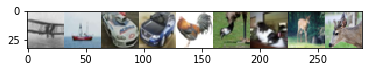

tensor([0.1492, 0.4898, 0.1069, 0.0251, 0.0039, 0.0155, 0.0035, 0.0066, 0.1996],
       device='cuda:0', dtype=torch.float64)


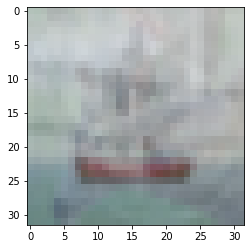

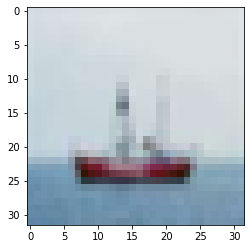

predicted ship
true ship
****************************************************************************************************


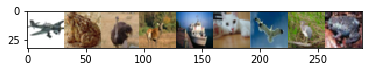

tensor([0.0194, 0.0721, 0.0374, 0.0869, 0.4560, 0.0854, 0.1046, 0.0045, 0.1337],
       device='cuda:0', dtype=torch.float64)


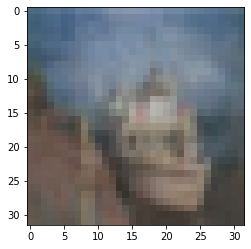

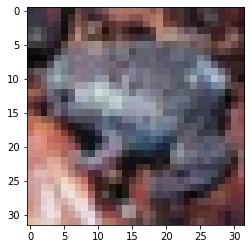

predicted ship
true ship
****************************************************************************************************


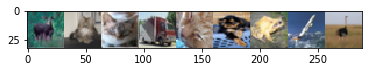

tensor([0.0254, 0.0419, 0.0272, 0.7919, 0.0343, 0.0010, 0.0013, 0.0090, 0.0680],
       device='cuda:0', dtype=torch.float64)


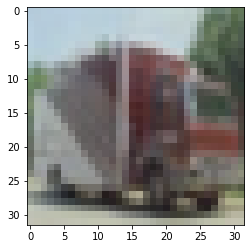

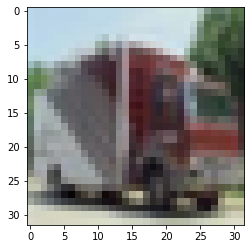

predicted truck
true truck
****************************************************************************************************


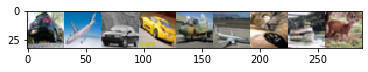

tensor([0.1125, 0.0027, 0.0196, 0.0005, 0.1219, 0.2913, 0.0389, 0.3865, 0.0260],
       device='cuda:0', dtype=torch.float64)


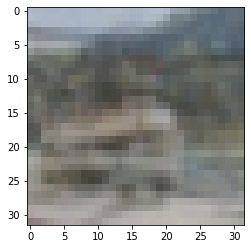

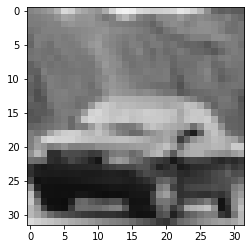

predicted horse
true ship
****************************************************************************************************


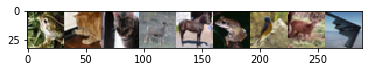

tensor([1.1333e-03, 2.4775e-03, 8.1860e-04, 3.8180e-03, 9.6878e-01, 1.6255e-03,
        9.2064e-03, 2.3814e-03, 9.7576e-03], device='cuda:0',
       dtype=torch.float64)


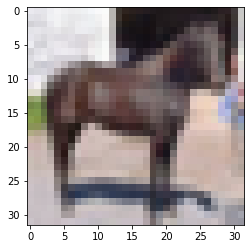

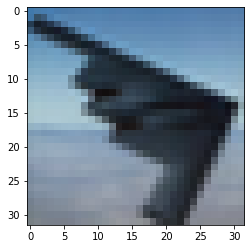

predicted horse
true horse
****************************************************************************************************


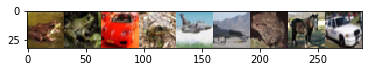

tensor([0.0012, 0.0027, 0.0017, 0.0012, 0.0064, 0.1747, 0.0085, 0.8023, 0.0013],
       device='cuda:0', dtype=torch.float64)


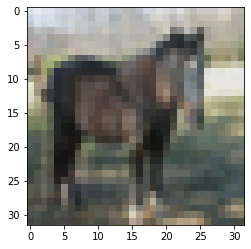

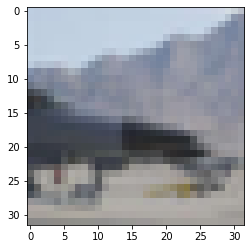

predicted horse
true horse
****************************************************************************************************


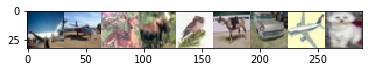

tensor([0.0519, 0.1672, 0.0646, 0.0123, 0.0418, 0.5202, 0.0147, 0.0187, 0.1086],
       device='cuda:0', dtype=torch.float64)


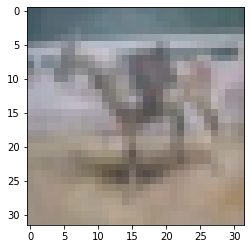

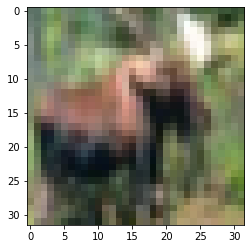

predicted horse
true horse
****************************************************************************************************


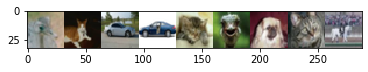

tensor([2.0178e-02, 4.4740e-04, 9.4717e-02, 1.1597e-01, 1.4546e-02, 3.7328e-02,
        1.3598e-02, 6.0149e-02, 6.4307e-01], device='cuda:0',
       dtype=torch.float64)


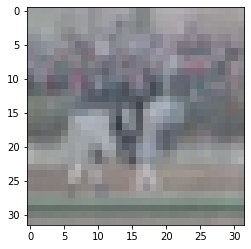

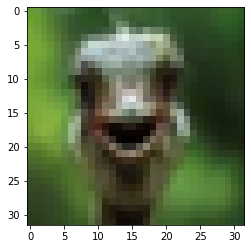

predicted horse
true horse
****************************************************************************************************


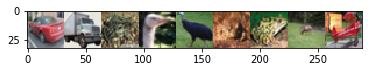

tensor([0.0049, 0.8338, 0.0549, 0.0020, 0.0084, 0.0181, 0.0044, 0.0351, 0.0385],
       device='cuda:0', dtype=torch.float64)


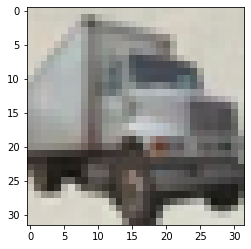

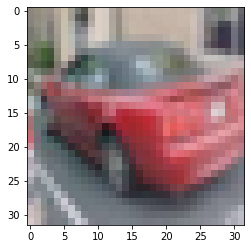

predicted truck
true truck
****************************************************************************************************


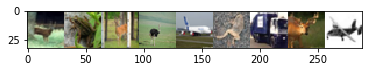

tensor([4.4255e-03, 3.8619e-03, 3.8620e-03, 1.3734e-03, 4.6013e-02, 5.9742e-03,
        9.2787e-01, 6.0765e-03, 5.3984e-04], device='cuda:0',
       dtype=torch.float64)


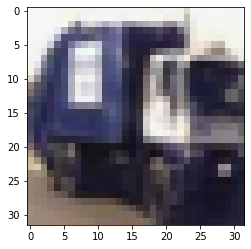

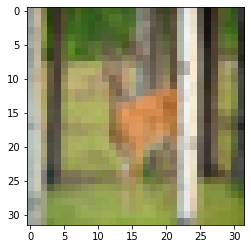

predicted truck
true truck
****************************************************************************************************


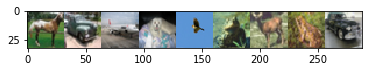

tensor([8.1434e-01, 1.3735e-03, 7.7530e-02, 2.2495e-02, 7.9774e-05, 4.7028e-03,
        8.1239e-03, 7.7610e-04, 7.0583e-02], device='cuda:0',
       dtype=torch.float64)


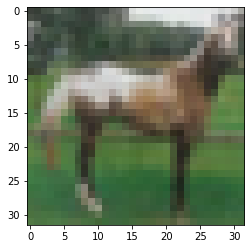

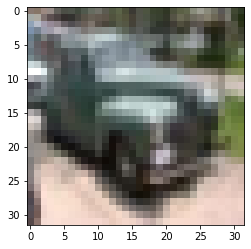

predicted horse
true horse
****************************************************************************************************


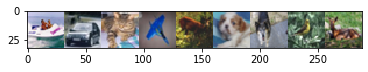

tensor([0.6429, 0.0366, 0.0108, 0.1908, 0.0362, 0.0350, 0.0155, 0.0227, 0.0096],
       device='cuda:0', dtype=torch.float64)


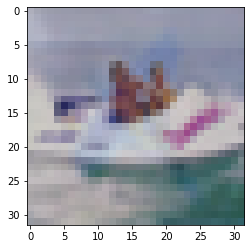

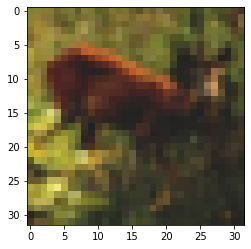

predicted ship
true ship
****************************************************************************************************


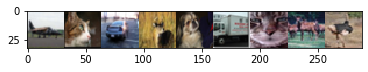

tensor([4.8999e-03, 3.8643e-03, 1.0121e-02, 3.3087e-04, 2.7835e-03, 9.5220e-01,
        2.2428e-03, 2.2438e-02, 1.1157e-03], device='cuda:0',
       dtype=torch.float64)


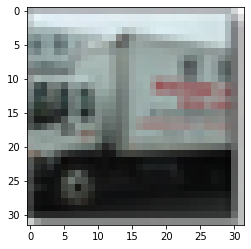

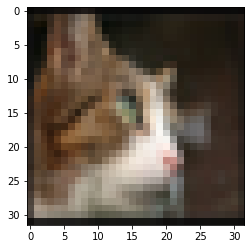

predicted truck
true truck
****************************************************************************************************


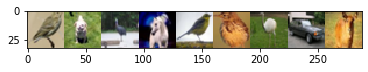

tensor([0.0065, 0.0024, 0.0485, 0.7340, 0.0968, 0.0125, 0.0393, 0.0523, 0.0075],
       device='cuda:0', dtype=torch.float64)


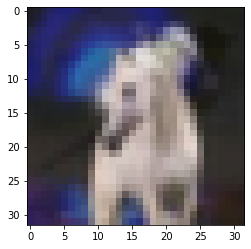

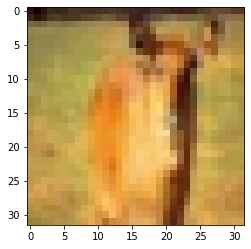

predicted ship
true horse
****************************************************************************************************


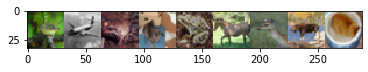

tensor([0.0029, 0.0055, 0.0178, 0.0288, 0.0060, 0.8244, 0.0652, 0.0246, 0.0248],
       device='cuda:0', dtype=torch.float64)


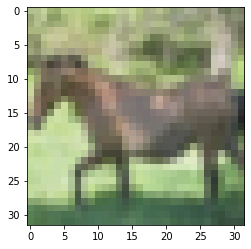

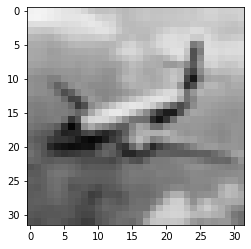

predicted horse
true horse
****************************************************************************************************


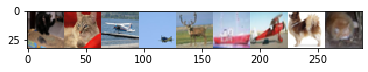

tensor([0.0170, 0.0038, 0.0469, 0.0483, 0.0646, 0.6813, 0.1039, 0.0075, 0.0266],
       device='cuda:0', dtype=torch.float64)


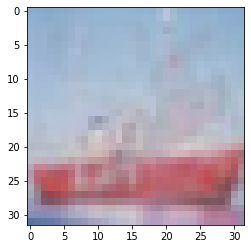

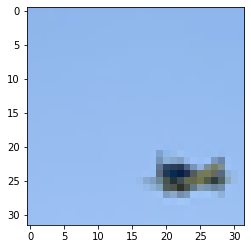

predicted ship
true ship
****************************************************************************************************


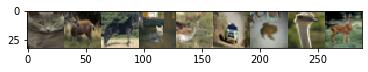

tensor([0.0955, 0.0856, 0.3792, 0.0487, 0.0654, 0.0732, 0.0669, 0.0092, 0.1763],
       device='cuda:0', dtype=torch.float64)


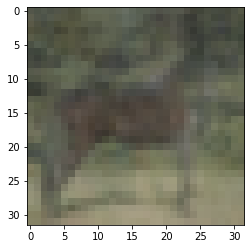

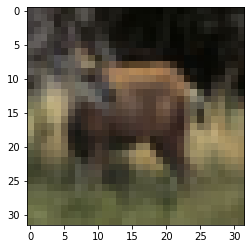

predicted horse
true horse
****************************************************************************************************


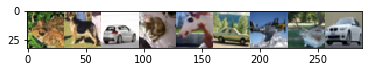

tensor([0.0722, 0.0361, 0.0447, 0.0083, 0.2347, 0.4896, 0.0243, 0.0849, 0.0052],
       device='cuda:0', dtype=torch.float64)


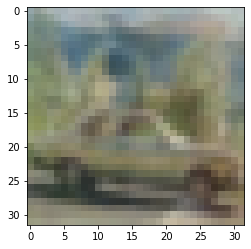

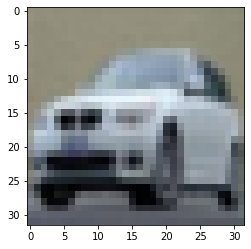

predicted horse
true horse
****************************************************************************************************


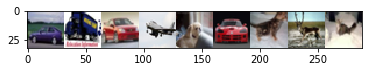

tensor([0.2297, 0.2908, 0.0502, 0.0100, 0.0789, 0.0027, 0.0886, 0.2428, 0.0063],
       device='cuda:0', dtype=torch.float64)


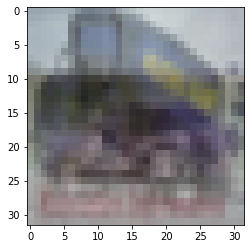

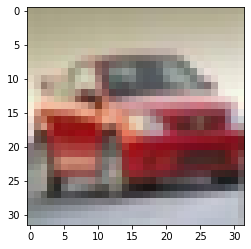

predicted truck
true truck
****************************************************************************************************


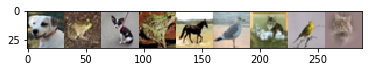

tensor([0.1240, 0.0015, 0.0053, 0.0031, 0.7627, 0.0370, 0.0059, 0.0013, 0.0592],
       device='cuda:0', dtype=torch.float64)


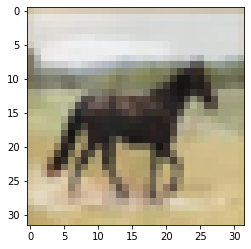

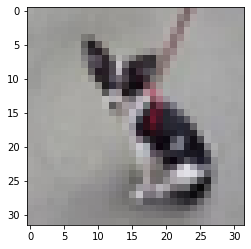

predicted horse
true horse
****************************************************************************************************


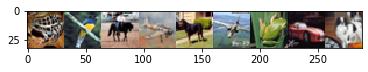

tensor([5.3419e-03, 1.5422e-04, 6.2328e-01, 1.1584e-01, 1.9902e-02, 8.8915e-02,
        2.9233e-02, 1.0364e-01, 1.3699e-02], device='cuda:0',
       dtype=torch.float64)


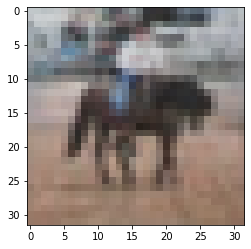

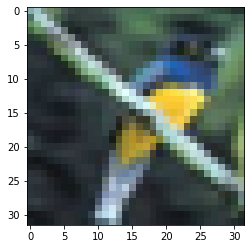

predicted horse
true horse
****************************************************************************************************


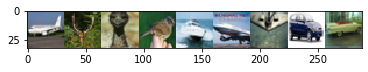

tensor([0.0152, 0.0025, 0.0187, 0.0191, 0.7743, 0.0715, 0.0077, 0.0241, 0.0670],
       device='cuda:0', dtype=torch.float64)


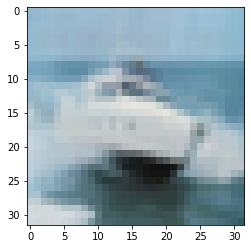

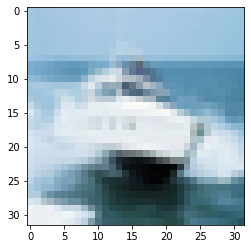

predicted ship
true ship
****************************************************************************************************


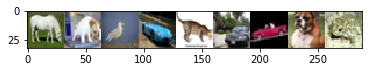

tensor([0.3992, 0.0366, 0.3779, 0.0765, 0.0129, 0.0177, 0.0108, 0.0507, 0.0177],
       device='cuda:0', dtype=torch.float64)


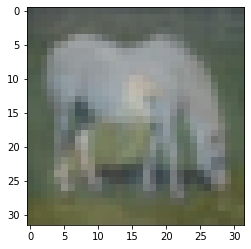

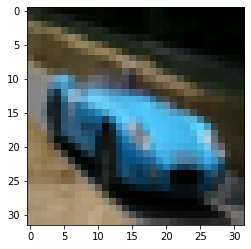

predicted horse
true horse
****************************************************************************************************


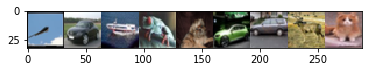

tensor([0.1322, 0.4194, 0.0944, 0.0246, 0.0239, 0.0749, 0.0937, 0.0859, 0.0508],
       device='cuda:0', dtype=torch.float64)


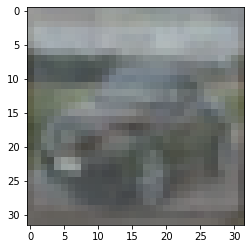

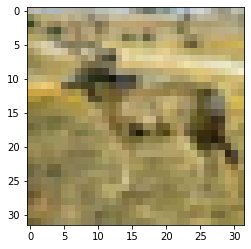

predicted ship
true ship
****************************************************************************************************


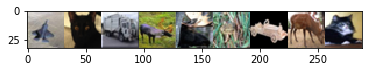

tensor([4.0589e-03, 1.4123e-03, 9.7891e-01, 4.2551e-05, 1.5681e-03, 2.2113e-03,
        4.1047e-03, 7.5975e-03, 9.2618e-05], device='cuda:0',
       dtype=torch.float64)


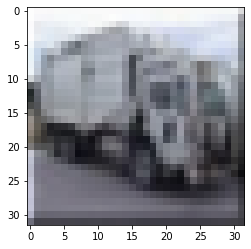

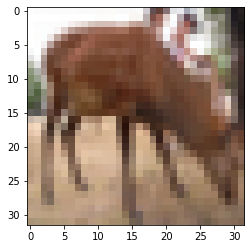

predicted truck
true truck
****************************************************************************************************


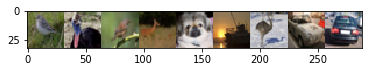

tensor([0.1241, 0.0049, 0.1296, 0.1791, 0.0396, 0.0887, 0.0882, 0.1715, 0.1742],
       device='cuda:0', dtype=torch.float64)


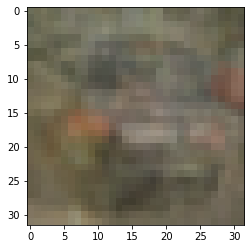

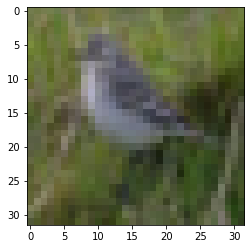

predicted horse
true ship
****************************************************************************************************


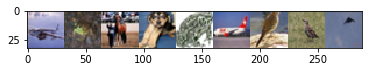

tensor([0.0144, 0.0670, 0.6849, 0.0092, 0.0175, 0.0794, 0.0064, 0.0494, 0.0718],
       device='cuda:0', dtype=torch.float64)


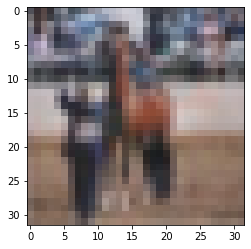

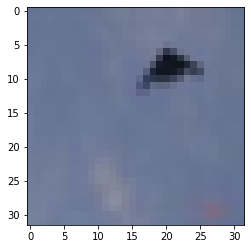

predicted horse
true horse
****************************************************************************************************


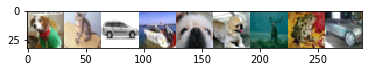

tensor([0.1147, 0.1038, 0.0452, 0.1757, 0.0335, 0.0168, 0.2481, 0.0065, 0.2557],
       device='cuda:0', dtype=torch.float64)


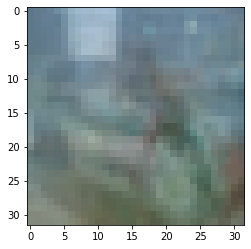

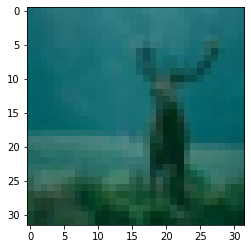

predicted truck
true ship
****************************************************************************************************


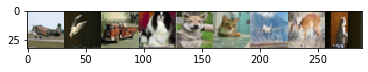

tensor([0.1201, 0.0321, 0.3057, 0.0102, 0.0180, 0.0598, 0.3840, 0.0618, 0.0083],
       device='cuda:0', dtype=torch.float64)


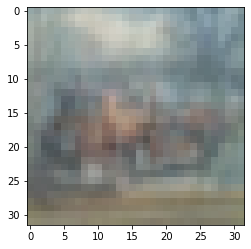

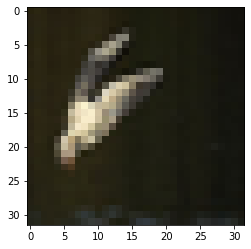

predicted truck
true truck
****************************************************************************************************


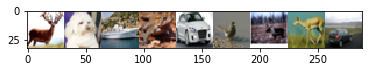

tensor([8.4626e-04, 7.8407e-03, 8.8360e-01, 1.4731e-03, 5.6322e-03, 9.6502e-03,
        3.8493e-02, 8.9632e-03, 4.3504e-02], device='cuda:0',
       dtype=torch.float64)


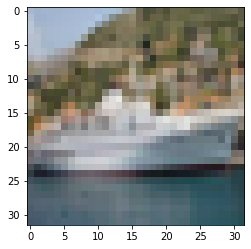

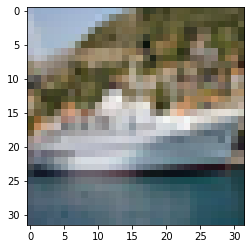

predicted ship
true ship
****************************************************************************************************


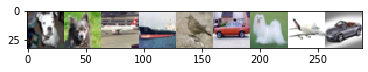

tensor([1.1945e-02, 2.9944e-04, 1.9529e-02, 9.1464e-01, 1.1362e-02, 2.4281e-02,
        3.5222e-03, 1.0002e-02, 4.4240e-03], device='cuda:0',
       dtype=torch.float64)


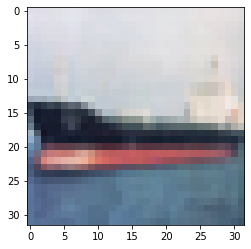

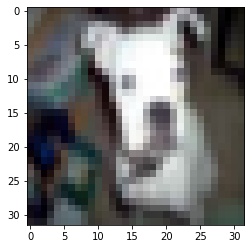

predicted ship
true ship
****************************************************************************************************


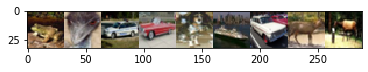

tensor([0.0076, 0.0013, 0.0061, 0.0384, 0.0237, 0.8545, 0.0040, 0.0573, 0.0070],
       device='cuda:0', dtype=torch.float64)


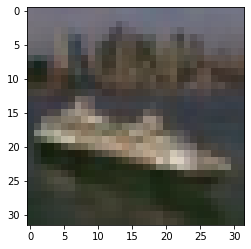

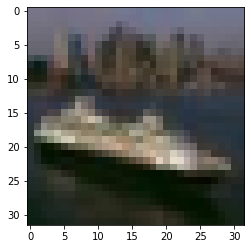

predicted ship
true ship
****************************************************************************************************


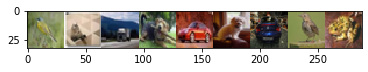

tensor([0.0067, 0.0788, 0.7459, 0.0139, 0.0031, 0.0453, 0.0898, 0.0086, 0.0078],
       device='cuda:0', dtype=torch.float64)


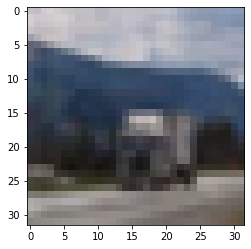

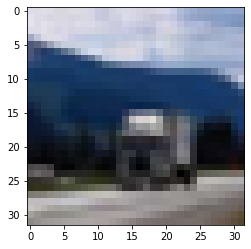

predicted truck
true truck
****************************************************************************************************


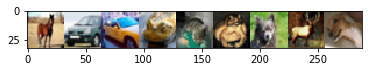

tensor([8.5951e-01, 5.5424e-02, 1.2182e-02, 4.2265e-02, 4.0854e-03, 6.5425e-03,
        2.9056e-04, 1.1929e-02, 7.7708e-03], device='cuda:0',
       dtype=torch.float64)


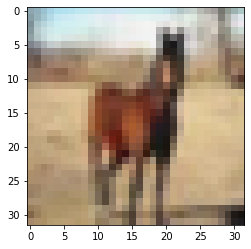

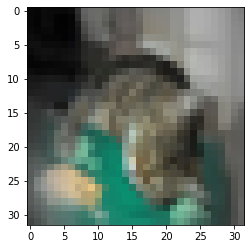

predicted horse
true horse
****************************************************************************************************


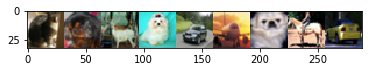

tensor([5.0563e-04, 6.3763e-03, 3.9794e-03, 9.6544e-04, 2.2463e-03, 1.2836e-03,
        1.6107e-04, 9.8409e-01, 3.9705e-04], device='cuda:0',
       dtype=torch.float64)


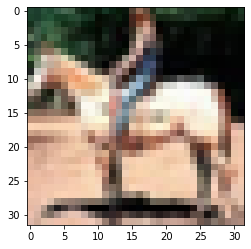

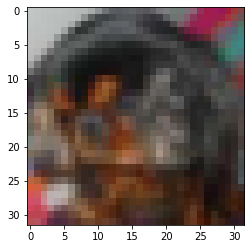

predicted horse
true horse
****************************************************************************************************


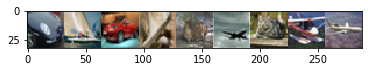

tensor([0.3610, 0.0369, 0.0087, 0.0126, 0.0575, 0.0566, 0.1015, 0.1558, 0.2092],
       device='cuda:0', dtype=torch.float64)


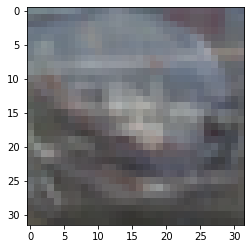

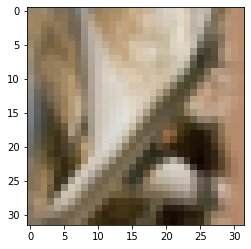

predicted ship
true ship
****************************************************************************************************


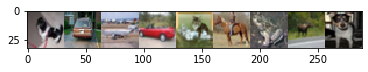

tensor([0.0124, 0.0638, 0.0961, 0.0055, 0.0052, 0.7772, 0.0088, 0.0067, 0.0244],
       device='cuda:0', dtype=torch.float64)


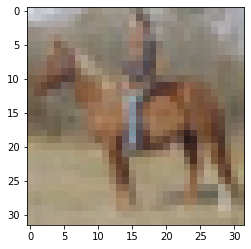

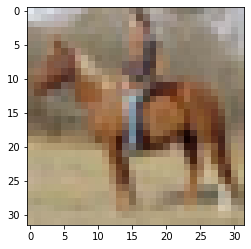

predicted horse
true horse
****************************************************************************************************


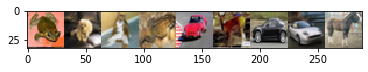

tensor([0.0025, 0.0009, 0.0046, 0.0031, 0.0029, 0.0952, 0.0109, 0.0148, 0.8651],
       device='cuda:0', dtype=torch.float64)


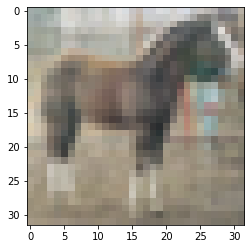

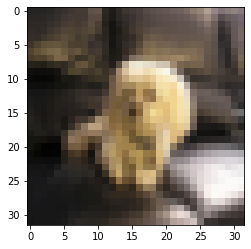

predicted horse
true horse
Accuracy of the network on the 10000 test images: 80 %
total correct 8085
total test set images 10000


In [28]:
correct = 0
total = 0
flag =1
with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)
    _, predicted = torch.max(outputs.data, 1)


    if flag==1 :
      for j in range (50):
        print("*"*100)
        img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
        display(img1.cpu())

        print(alphas[j])

        img2 = avg_images[j]
        display(img2.cpu())

        img3 = inputs[j][fore_idx_test[j]]
        display(img3.cpu())

        print("predicted", classes[predicted[j]+7])
        print("true", classes[labels[j]+7])

      flag =0


    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
print("total correct", correct)
print("total test set images", total)

In [29]:
a = torch.tensor([0.0071, 0.0466, 0.0025, 0.0282, 0.0140, 0.0067, 0.0145, 0.8750, 0.0055])

In [30]:
print(torch.argmax(a) == 7)
print(batch)

tensor(True)
250


In [31]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

train_loader1 = DataLoader( msd,batch_size= batch ,shuffle=False)
with torch.no_grad():
  for data in train_loader1:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)
    _, predicted = torch.max(outputs.data, 1)
    
    for j in range (batch):
      focus = torch.argmax(alphas[j])
      
      if(alphas[j][focus] >= 0.5):
        argmax_more_than_half +=1
      else:
        argmax_less_than_half +=1
        
      if(focus == fore_idx[j] and predicted[j] == labels[j]):
        focus_true_pred_true += 1
        
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true +=1
        
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false +=1
        
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false +=1
      
#       print("*"*100)
#       img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
#       display(img1)

#       print(alphas[j])

#       img2 = avg_images[j]
#       display(img2)

#       img3 = inputs[j][fore_idx[j]]
#       display(img3)

#       print("predicted", classes[predicted[j]+7])
#       print("true", classes[labels[j]+7])

     
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

Accuracy of the network on the 30000 train images: 97 %
total correct 29328
total train set images 30000
focus_true_pred_true 24099
focus_false_pred_true 5229
focus_true_pred_false 175
focus_false_pred_false 497
argmax_more_than_half 21415
argmax_less_than_half 8585


In [32]:
bg_idx = np.random.randint(0,35000,8)
fg_idx = np.random.randint(0,15000)
fg = np.random.randint(0,9)
fore_idx_test.append(fg)
image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
test_images.append(image_list)
test_label.append(label)
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)

    _, predicted = torch.max(outputs.data, 1)
    
    for j in range (batch):
      focus = torch.argmax(alphas[j])
      
      if(alphas[j][focus] >= 0.5):
        argmax_more_than_half +=1
      else:
        argmax_less_than_half +=1
        
      if(focus == fore_idx[j] and predicted[j] == labels[j]):
        focus_true_pred_true += 1
        
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true +=1
        
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false +=1
        
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false +=1
      
#       print("*"*100)
#       img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
#       display(img1)

#       print(alphas[j])

#       img2 = avg_images[j]
#       display(img2)

#       img3 = inputs[j][fore_idx[j]]
#       display(img3)

#       print("predicted", classes[predicted[j]+7])
#       print("true", classes[labels[j]+7])

     
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

Accuracy of the network on the 30000 train images: 80 %
total correct 8085
total train set images 10000
focus_true_pred_true 7025
focus_false_pred_true 1060
focus_true_pred_false 607
focus_false_pred_false 1308
argmax_more_than_half 6550
argmax_less_than_half 3450


In [33]:
# epoch = 100
# for i in range(epoch):
#   if (i %40) <20:
#     print("What",i)
#   elif (i%40)>20:
#     print("Where",i)